# Статистический анализ сервиса аренды самокатов GoFast

Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. 

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. 

Сервисом можно пользоваться:
1. без подписки:
    - абонентская плата отсутствует;
    - стоимость одной минуты поездки — 8 рублей;
    - стоимость старта (начала поездки) — 50 рублей;
2. с подпиской Ultra:
    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки — 6 рублей;
    - стоимость старта — бесплатно.
    
**Описание данных**

В основных данных есть информация о пользователях, их поездках и подписках:

1) Пользователи — users_go.csv:
- user_id - уникальный идентификатор пользователя
- name - имя пользователя
- age - возраст
- city - город
- subscription_type - тип подписки (free, ultra)

2) Поездки — rides_go.csv:
- user_id -	уникальный идентификатор пользователя
- distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)
- duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- date - дата совершения поездки

3) Подписки — subscriptions_go.csv:
- subscription_type - тип подписки
- minute_price - стоимость одной минуты поездки по данной подписке
- start_ride_price - стоимость начала поездки
- subscription_fee - стоимость ежемесячного платежа

**Задача**: проанализировать данные и проверить следующие гипотезы, которые могут помочь бизнесу вырасти:
- понять, тратят ли пользователи с подпиской больше времени на поездки;
- определить, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров, т.е. оптимального с точки зрения износа самоката;
- проверить, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Для этого необходимо будет выполнить следующие действия:
1. Загрузить данные и изучить общую информацию о каждом датафрейме.

2. Предобработать данные: изменить, где это необходимо, типы данных; обработать дубликаты и пропущенные значения; создать по необходимости новые столбцы.

3. Провести исследовательский анализ данных: описать и визуализировать общую информацию о пользователях и поездках;

4. Объединить данные о пользователях, поездках и подписках и визуализировать информацию о расстоянии и времени поездок для пользователей обеих категорий.

5. Подсчитать выручку.

6. Проверить гипотезы.

7. Сделать общий вывод.

Вызовем необходимые для работы библиотеки:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

#### Загрузка данных

1.1 Считаем CSV-файлы с данными с помощью библиотеки pandas и сохраним их в датафреймы. Пути к файлам:
- /datasets/users_go.csv - users;
- /datasets/rides_go.csv - rides;
- /datasets/subscriptions_go.csv - subscriptions:

In [2]:
users = pd.read_csv('/datasets/users_go.csv')

rides = pd.read_csv('/datasets/rides_go.csv')

subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

1.2 Выведем первые строки каждого набора данных и изучим общую информацию о каждом датафрейме.

In [3]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Как можно видеть, в датафрейме с пользователями имеется 1565 строк и 5 столбцов, причём в каждом столбце отсутствуют пропущенные значения, а тип данных в каждом столбце соответствует требуемому.

Изучим общую информацию о поездках:

In [5]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


В данных о поездках присутствует 18068 строк и 4 столбца, где также отсутствуют пропуски и типы данных в целом соответсвуют необходимым, однако столбец с датами - 'date' имеет тип данных не datetime, а object, что в дальнейшем будет исправлено.

Наконец, рассмотрим датафрейм с информацией о подписках. 

In [7]:
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Здесь всего 2 строки и 4 столбца, пропусков нет, а типы данных не требуют изменений.

####  Предобработка данных

2.1 Приведём столбец date к типу datetime библиотеки pandas:

In [9]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

Проверим, что изменения прошли успешно, вызвав метод info():

In [10]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


2.2 Создадим новый столбец с номером месяца на основе столбца date:

In [11]:
rides['month'] = pd.DatetimeIndex(rides['date']).month

Проверим, правильно ли отображаются месяцы в новом столбце:

In [12]:
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Дополнительно проверим, за какой период у нас имеются данные. Для этого к столбцу 'date' датафрейма rides применим метод describe(), а к столбцу 'month' - метод nunique():

In [13]:
rides['date'].describe(datetime_is_numeric=True)

count                            18068
mean     2021-06-30 19:47:21.266327296
min                2021-01-01 00:00:00
25%                2021-04-02 00:00:00
50%                2021-06-30 00:00:00
75%                2021-09-28 00:00:00
max                2021-12-30 00:00:00
Name: date, dtype: object

In [14]:
rides['month'].nunique()

12

Итак, у нас имеются данные за все 12 месяцев 2021 года.

Всё верно, переходим к следующему заданию.

2.3 Проверим наличие пропущенных значений и дубликатов в датафреймах. Обработаем их, если такие значения присутствуют.

Сначала изучим наличие пропущенных значений в данных о пользователях, применив методы isna() и sum():

In [15]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

В датафрейме о пользователях отсутствуют пропуски. Проверим наличие явных дубликатов, применив методы duplicated() и sum():

In [16]:
users.duplicated().sum()

31

Итак, в данных о пользователях присутсвует 31 строка-дубликат. Удалим их, вызвав метод drop_duplicates():

In [17]:
users = users.drop_duplicates()

Убедимся, что датафрейм не содержит явных дубликатов:

In [18]:
users.duplicated().sum()

0

Далее изучим пропуски и дубликаты в датафрейме о поездках:

In [19]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [20]:
rides.duplicated().sum()

0

Как можно видеть, в этом датафрейме отсутствуют пропущенные значения и явные дубликаты.

Осталось рассмотреть данные о подписках:

In [21]:
subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [22]:
subscriptions.duplicated().sum()

0

Как и в предыдущем случае, в датафрейме о подписках отсутствуют пропуски и строки-дубликаты.

Таким образом, среди трёх рассмотренных датафреймов только в одном, где содержится информация о пользователях, имелась всего 31 строка-дубликат, которые были удалены из более ччем 1500 строк. При этом во всех датафреймах отсутствуют пропущенные значения. Всё это говорит о высоком качестве представленных исходных данныхэ

#### Исследовательский анализ данных

Опишем и визуализируем общую информацию о пользователях и поездках:

3.1 частота встречаемости городов;

Сначала изучим общие характеристики столбца 'city' в датафрейме users, применив метод describe():

In [23]:
users['city'].describe()

count          1534
unique            8
top       Пятигорск
freq            219
Name: city, dtype: object

Так, всего в данных присутствует 8 городов, встречающихся 1534 раз. Наиболее распространён Пятигорск: его частота равна 219.

Посмотрим, как распределена частота встречаемости остальных семи городов. Для этого постоим горизонтальную стобчатую диаграмму и таблицу для столбца 'city', к которому предварительно применим метод value_counts():

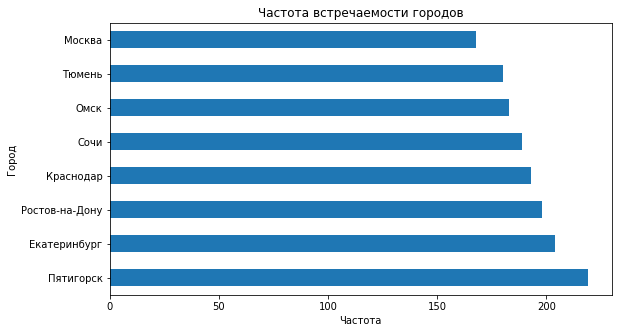

In [24]:
users['city'].value_counts().plot(
    title='Частота встречаемости городов', 
    kind='barh',  
    figsize=(9,5),
);
plt.xlabel("Частота")
plt.ylabel("Город");

In [25]:
users['city'].value_counts(ascending=True)

Москва            168
Тюмень            180
Омск              183
Сочи              189
Краснодар         193
Ростов-на-Дону    198
Екатеринбург      204
Пятигорск         219
Name: city, dtype: int64

Итак, наиболее часто в датафрейме users встречаются города Юга России: Пятигорск, Ростов-на-Дону, Крансодар и Сочи. Они встречаются с частотой от 189 до 219 раз. Причём на втором месте после Пятигорска расположися Екатеринбург с частотой встречаемости 204 раза. Реже всего в представленной датафрейме о пользователя встречается Москва с частотой 168 раза, а такие сибирские города, как Омск и Тюмень, встречаются несколько чаще: примерно 180 раз.

В целом можно сказать, что сервис популярен в южных городах России и в Екатеринбурге, т.е. вдали от крупнейших городов страны: Москвы и Санкт-Петербурга, что, вероятно, объясняется меньшей конкуренцией в регионах.

3.2 соотношение пользователей с подпиской и без подписки;

Сначала визуализируем информацию о распределении пользователей с подпиской и без. Для этого сгруппируем данные в датафрейме users по типу подписки и посчитаем количество пользователей с подпиской и без, после чего построим круговую диаграмму:

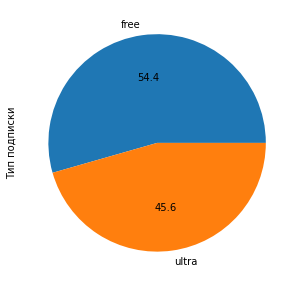

In [26]:
users.groupby('subscription_type')['user_id'].count().plot(
    kind='pie', 
    ylabel='Тип подписки',
    autopct="%.1f",
    figsize=(10,5)
);

Таким образом, примерно 54.4 % пользователей обходятся без подписки на сервис аренды самокатов GoFast, а, соответственно, около 45.6 % процентов имеют подписку 'ultra'. Это может свидетельствовать о том, что довольно высокая доля пользователей осознали преимущества подписки и выбрали такой вариант взаимодействия с сервисом аренды самокатов. В дальнейшем это может подтвердиться тем, что такие пользователи меньше платят за оказываемые сервисом услуги, в отличие от пользователей без подписки.

3.3 возраст пользователей;

Чтобы изучить возраст пользователей, применим к столбцу 'age' отдельно методы describe() и hist():

In [27]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

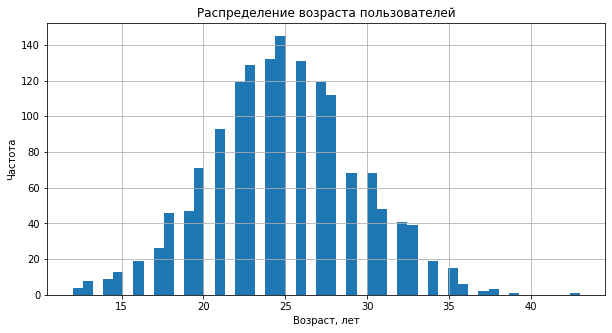

In [28]:
plt.figure(figsize=(10, 5))

users['age'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Распределение возраста пользователей')
plt.xlabel("Возраст, лет")
plt.ylabel("Частота")
plt.show();

Как можно видеть, возраст пользователей варьируется от 12 до 43 лет, причём среднее и медианное значения очень близки: 24.9 и 25.0 лет, соответственно, а стандартное отклонение составляет всего около 4.6 лет, что говорит об отсутствии выбросов и аномалий в данном столбце. Кроме того, график распределения пользователей сервисом аренды самокатов GoFast по возрастам демонстрирует приблизительно характер нормального распределения. Всё это говорит о том, что сервис популярен в основном среди молодёжи (от 14 до 35 лет), что, возможно, объясняется определённой сложностью использования самоката, вызванной необходимостью поддержания равновесия, обладания достаточной скоростью реакции и др., т.е. чертами, которые могут не так хорошо выражены у детей (в данной случае младше 12 лет) и у людей среднего возраста (здесь, старше 43 лет).

3.4 расстояние, которое пользователь преодолел за одну поездку;

Для этого сначала посмотрим общие характеристики столбца 'distance':

In [29]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Как можно видеть, минимальное расстояние равняется примерно 0.86 м, что явно меньше разумного расстояния за одну поездку. Посмотрим, сколько в данных неправдоподобно коротких поездок, взяв в качестве минимального расстояния - 100 м:

In [30]:
len(rides.query('distance <= 100')) / len(rides['distance'])

0.004317024573832189

Менее 0.5 % поездок имеют протяжённость менее 100 м, тогда можно удалить эти значения из датафрейма rides:

In [31]:
rides = rides.query('distance >= 100')

rides['distance'].describe()

count    17990.000000
mean      3083.724675
std       1101.442969
min        102.323624
25%       2551.031541
50%       3137.750590
75%       3779.705094
max       7211.007745
Name: distance, dtype: float64

В итоге количество значений в датафрейме уменьшилось с 18068 до 17990, т.е. на 78. Построим теперь гистограмму:

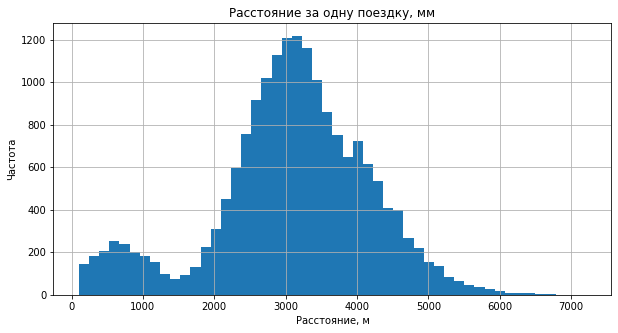

In [32]:
plt.figure(figsize=(10, 5))

rides['distance'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Расстояние за одну поездку, мм')
plt.xlabel("Расстояние, м")
plt.ylabel("Частота")
plt.show();

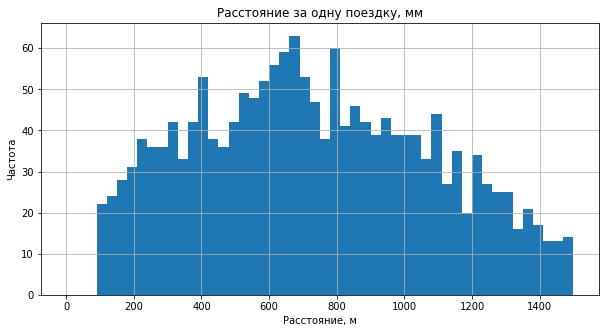

In [33]:
plt.figure(figsize=(10, 5))

rides['distance'].hist(
    bins=50,
    range=(0,1500),
    grid = True,
    linewidth=3,
)
plt.title('Расстояние за одну поездку, мм')
plt.xlabel("Расстояние, м")
plt.ylabel("Частота")
plt.show();

Так, на основании представленных данных можно сказать, что распределение расстояния, которое преодолевали пользователи за одну  поездку, имеет два пика: первый, более малый, в области от 0 до 1.5 км с максимум приблизительно в 700 м, и второй, гораздо больший, между 1.5 и 7 км с максимумом в области 3 км. Оба этих пика по отдельности демонстрируют приблизительно характер нормального распределения.

Такие наблюдения могут объясняться тем, что некоторым пользователям необходимо очень быстро преодолеть короткую дистанцию, а большинству самокат требуется для длинных перемещений, вплоть до 7 км.

В целом можно сказать, что люди пользуются самокатом, чтобы преодолеть расстояние, которое можно пройти пешком, но 
необходимо обеспечить относительно высокую скорость передвижения, чтобы не терять много времени на дорогу.

3.5 продолжительность поездок.

Чтобы определить продолжительность поездок, аналогичным образом изучим общую информацию о столбце 'duration' и построим гистограмму:

In [34]:
rides['duration'].describe()

count    17990.000000
mean        17.849271
std          6.062243
min          0.500000
25%         13.655664
50%         17.709849
75%         21.742960
max         40.823963
Name: duration, dtype: float64

Как можно видеть, продолжительность одной поездки варьируется от 30 секунд до почти 41 минуты. 30 секунд представляется крайне маленьким временем поездки. Построим гистограмму:

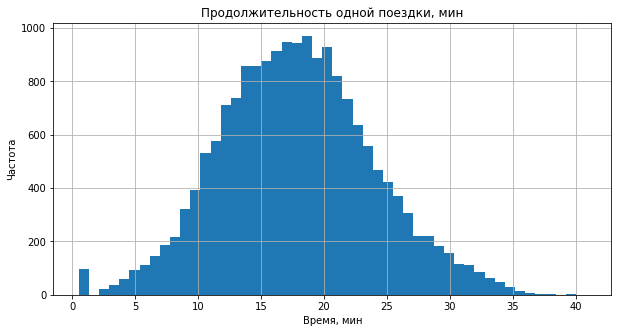

In [35]:
plt.figure(figsize=(10, 5))

rides['duration'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Продолжительность одной поездки, мин')
plt.xlabel("Время, мин")
plt.ylabel("Частота")
plt.show();

Распределение продолжительности одной поездки имеет в целом вид нормального распределения, однако действительно в области до примерно 2 минут имеется аномально большое количество поездок. Посмотрим на них:

In [36]:
rides.query('duration < 2')

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


Все такие поездки имеют продолжительность ровно 30 секунд, и за это время как будто преодолевается расстояние примерно в 5 км, что наводит на мысль о неправдоподобности такой продолжительности и необходимости удалить эти данные, предварительно убедившись, что мы удалим незначительную долю данных (менее 1 %):

In [37]:
len(rides.query('duration < 2')) / len(rides['duration'])

0.0052807115063924406

Отлично: всего около 0.5 % данных имеют аномально низкие значения продолжительности поездки, можно смело их удалить.
Затем снова вызовем методы describe() и hist():

In [38]:
rides = rides.query('duration >= 2')

rides['duration'].describe()

count    17895.000000
mean        17.941374
std          5.944696
min          2.222598
25%         13.724161
50%         17.744733
75%         21.764967
max         40.823963
Name: duration, dtype: float64

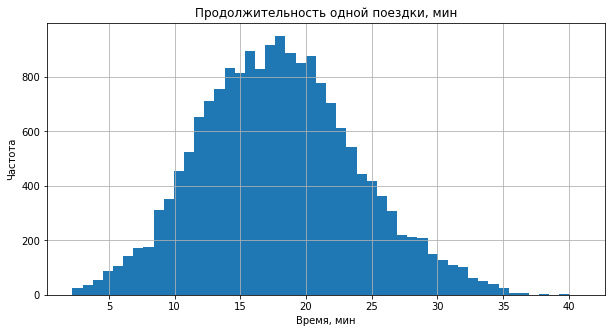

In [39]:
plt.figure(figsize=(10, 5))

rides['duration'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Продолжительность одной поездки, мин')
plt.xlabel("Время, мин")
plt.ylabel("Частота")
plt.show();

Ещё 95 значений были удалены. Зато теперь данные правдоподобны и по ним можно сказать, что  среднее и медианное значения отличаются незначительно: 17.94 и 17.74 мин, а стандартное отклонение составляет около 6 мин, что говорит об отсутствии выбросов и аномалий.

Таким образом, в среднем люди используют самокат в течение около 18 минут (примерно 1/3 часа), преодолевая за это время в среднем около 3 км. То есть их средняя скорость движения составляет порядка 9 км/ч, что больше средней скорости ходьбы (около 5-6 км/ч) в 1.5-2 раза. Это говорит о преимуществе перемещения на самокате: выше скорость, а значит, короче время движения, а также отсутствие усталости от ходьбы.

#### Объединение данных

4.1 Объединим данные о пользователях, поездках и подписках в один датафрейм - df_all. Для этого воспользуемся методом merge() и выведем первые 5 строк объединённого датафрейма на экран:

In [40]:
df_all = users.merge(rides, on='user_id').merge(subscriptions, on='subscription_type')

df_all.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


Проверим, что количество строк в созданном датафрейме совпадает с исходным датафреймом rides:

In [41]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17895 entries, 0 to 17894
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17895 non-null  int64         
 1   name               17895 non-null  object        
 2   age                17895 non-null  int64         
 3   city               17895 non-null  object        
 4   subscription_type  17895 non-null  object        
 5   distance           17895 non-null  float64       
 6   duration           17895 non-null  float64       
 7   date               17895 non-null  datetime64[ns]
 8   month              17895 non-null  int64         
 9   minute_price       17895 non-null  int64         
 10  start_ride_price   17895 non-null  int64         
 11  subscription_fee   17895 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


Всё нормально: данные не потерялись и не были добавлены.

4.2 Создадим ещё два датафрейма из датафрейма, созданного на этапе 4.1:
- c данными о пользователях с подпиской - df_ultra;
- с данными о пользователях без подписки - df_free.

Выведем первые 5 строк каждого датафрейма:

In [42]:
df_ultra = df_all.query('subscription_type == "ultra"')

df_ultra.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [43]:
df_free = df_all.query('subscription_type == "free"')

df_free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


4.3 Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

Для этого для обоих датафреймов: df_ultra и df_free, - построим необходимые сводные таблицы, данные из которых визуализируем с помощью методы plot(), а также вызовем метод describe():

In [44]:
df_ultra['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

In [45]:
df_free['distance'].describe()

count    11395.000000
mean      3048.710848
std       1214.976625
min        102.323624
25%       2374.272932
50%       3111.679928
75%       3890.641189
max       7066.003772
Name: distance, dtype: float64

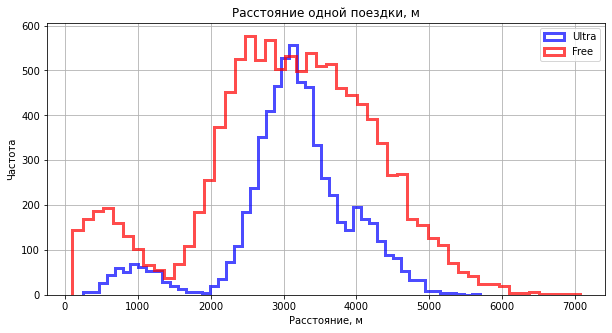

In [46]:
plt.figure(figsize=(10, 5))

df_ultra['distance'].hist(bins=50, alpha=0.7,
                            label='Ultra', grid = True, color='blue', histtype='step', linewidth=3)

df_free['distance'].hist(bins=50, alpha=0.7,
                            label='Free', grid = True, color='red', histtype='step', linewidth=3)


plt.legend()
plt.title('Расстояние одной поездки, м')
plt.xlabel("Расстояние, м")
plt.ylabel("Частота")
plt.show();

Как можно видеть, распределение расстояний для пользователей с подпиской имеет три ярко выраженных пика: первый в области до 2 км с максимумом в 1000 м, второй, самый большой, от 2 до 5 км и третий, у которого отчётливо видно только правую часть, от 4 ( область максимума) до почти 6 км. Причём среднее и медианное значения различаются не сильно: 3115.4 м и 3148.6 м, а стандартное отклонение составляет около 837 м. Каждый пик такого распределения в целом подобен нормальному.

Распределение расстояний для пользователей без подписки имеет 2 пика: до примерно 1.5 км и от 1.5 до 7 км. Причём первый пик не достаточно похож на нормальное распределение, т.к. левая часть на имеет затухающего хвоста: минимальное расстояние, около 100 м, преодолевалось довольно часто - около 150 раз. Второй пик имеет уширение в середине, от 2 до 4.5 км, что также отличается от характера нормального распределения, т.е. разброс данных здесь больше, чем для пользователей с подпиской. Так, среднее и медианное значения различаются уже довольно сильно: 3048.7 м и 3111.7 м, соответственно, а стандартное отклонение составляет более 1200 м. 

В целом можно сказать, что пользователи с подпиской имеют меньший диапазон расстояний и распределяются по расстояниям в большем приближении к нормальному распределнию, чем пользователи без подписки, которые чаще преодолевают расстояния от 2 до 5 км.


Теперь изучим продолжительность одной поездки для разных категорий пользователей: 

In [47]:
df_ultra['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

In [48]:
df_free['duration'].describe()

count    11395.000000
mean        17.598770
std          6.121051
min          2.222598
25%         13.167298
50%         17.437023
75%         21.677612
max         34.948498
Name: duration, dtype: float64

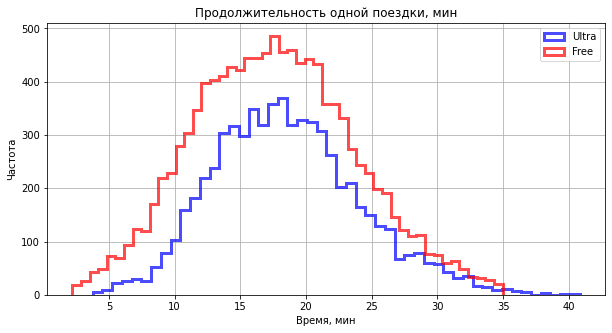

In [49]:
plt.figure(figsize=(10, 5))

df_ultra['duration'].hist(bins=50, alpha=0.7,
                            label='Ultra', grid = True, color='blue', histtype='step', linewidth=3)

df_free['duration'].hist(bins=50, alpha=0.7,
                            label='Free', grid = True, color='red', histtype='step', linewidth=3)


plt.legend()
plt.title('Продолжительность одной поездки, мин')
plt.xlabel("Время, мин")
plt.ylabel("Частота")
plt.show();

Так, поездки для пользователей с подпиской 'ultra' длятся от почти 4 до около 41 минуты. При этом среднее и медианное значения практически равны друг другу: 18.54 и 18.18 мин, соответственно, а стандартное отклонение составляет менее 6 минут, что говорит об отсутствии аномалий и выбросов в этих значениях.

Что касается продолжительности одной поездки для пользователей без подписки, то она характеризуется временным отрезком: от четь более 2 минут до почти 35 минут, причём среднее и медианное значения также очень близки: 17.60 и 17.44 мин, соответственно, а стандартное отклонение составляет немногим более 6, что также говорит об отсутствии аномалий и выбросов в этих значениях.

В целом можно видеть, что за одинаковую продолжительность пользователи без подписки чаще совершали поездки, чем пользователи с подпиской.

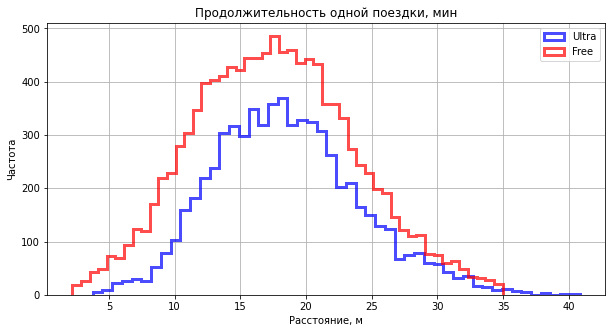

In [50]:
#  код ревьюера
plt.figure(figsize=(10, 5))

df_ultra['duration'].hist(bins=50, alpha=0.7,
                            label='Ultra', grid = True, color='blue', histtype='step', linewidth=3)

df_free['duration'].hist(bins=50, alpha=0.7,
                            label='Free', grid = True, color='red', histtype='step', linewidth=3)


plt.legend()
plt.title('Продолжительность одной поездки, мин')
plt.xlabel("Расстояние, м")
plt.ylabel("Частота")
plt.show();

#### Подсчёт выручки

5.1 Создадим датафрейм с агрегированными данными (df_agg) о поездках на основе датафрейма с объединёнными данными из шага 4: найдём суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

Сначала в датафрейме df_all округлим продолжительность каждой поездки(значения в столбце 'duration') до следующего целого числа, применив функцию np.ceil():

In [51]:
df_all['duration'] = np.ceil(df_all['duration'])

df_all['duration']

0        26.0
1        16.0
2         7.0
3        19.0
4        27.0
         ... 
17890    20.0
17891    22.0
17892    19.0
17893    17.0
17894    16.0
Name: duration, Length: 17895, dtype: float64

Теперь из датафрейма df_all создадим сводную таблицу, присвоив ей имя df_agg, где сгруппируем данные по 'user_id' (чтобы учесть каждого пользователя), 'month' (чтобы учесть каждый месяц) и 'subscription_type' (что знать, к какому типу подписки относится пользователь), в качестве значений возьмём 'distance' и 'duration', и применим к ним селективно функции 'sum' и 'count': 

In [52]:
df_agg = df_all.pivot_table(
    index=['user_id', 'month', 'subscription_type'],
    values=['distance', 'duration'],
    aggfunc={'distance':['sum', 'count'],
            'duration':'sum'}
)

Переименуем столбцы в df_agg в соответствии с заданием и выведем датафрейм:

In [53]:
df_agg.columns = ['trip_count', 'distance_sum', 'duration_sum']
df_agg

trip_count  distance_sum  duration_sum
user_id month subscription_type                                        
1       1     ultra                       2   7027.511294          42.0
        4     ultra                       1    754.159807           7.0
        8     ultra                       2   6723.470560          46.0
        10    ultra                       2   5809.911100          32.0
        11    ultra                       3   7003.499363          56.0
...                                     ...           ...           ...
1534    6     free                        2   3409.468534          26.0
        8     free                        2   7622.453034          48.0
        9     free                        1   4928.173852          23.0
        11    free                        4  13350.015305          78.0
        12    free                        1   2371.711192          16.0

[11280 rows x 3 columns]

5.2 В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратимся к информации об условиях оплаты для подписчиков и тех, у кого нет подписки.

Помесячная выручка считается по формуле: 

стоимость старта поездки ×  количество поездок + стоимость одной минуты поездки × общая продолжительность всех поездок в минутах + стоимость подписки.

Для расчёта помесячной выручки сначала объединим df_agg и subscriptions по столбцу 'subscription_type': 

In [54]:
df_agg = df_agg.merge(subscriptions, on='subscription_type')

df_agg

,subscription_type,trip_count,distance_sum,duration_sum,minute_price,start_ride_price,subscription_fee
0,ultra,2,7027.511294,42.0,6,0,199
1,ultra,1,754.159807,7.0,6,0,199
2,ultra,2,6723.470560,46.0,6,0,199
3,ultra,2,5809.911100,32.0,6,0,199
4,ultra,3,7003.499363,56.0,6,0,199
...,...,...,...,...,...,...,...
11275,free,2,3409.468534,26.0,8,50,0
11276,free,2,7622.453034,48.0,8,50,0
11277,free,1,4928.173852,23.0,8,50,0
11278,free,4,13350.015305,78.0,8,50,0


Далее создадим в объединённом датафрейме df_agg столбец 'month_profit', значения для которого передадим с помощью формулы расчёта помесячной выручки, проведя арифметические операции над другими столбцами:

In [55]:
df_agg['month_profit'] = df_agg['start_ride_price'] * df_agg['trip_count'] +  df_agg['minute_price'] * df_agg['duration_sum'] + \
df_agg['subscription_fee']

df_agg

,subscription_type,trip_count,distance_sum,duration_sum,minute_price,start_ride_price,subscription_fee,month_profit
0,ultra,2,7027.511294,42.0,6,0,199,451.0
1,ultra,1,754.159807,7.0,6,0,199,241.0
2,ultra,2,6723.470560,46.0,6,0,199,475.0
3,ultra,2,5809.911100,32.0,6,0,199,391.0
4,ultra,3,7003.499363,56.0,6,0,199,535.0
...,...,...,...,...,...,...,...,...
11275,free,2,3409.468534,26.0,8,50,0,308.0
11276,free,2,7622.453034,48.0,8,50,0,484.0
11277,free,1,4928.173852,23.0,8,50,0,234.0
11278,free,4,13350.015305,78.0,8,50,0,824.0


#### Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

6.1 Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим гипотезу. Используем исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Чтобы подтвердить или опровергнуть гипотезу, необходимо провести статистический анализ, использовав t-тест.

В качестве нулевой гипотезы примем, что пользователи с подпиской такое же время на поездки, что и пользователи без подписки. Тогда альлтернативная гипотеза - пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.

Уровень статистической значимости зададим равным 5 %.

Теперь проведём проверку:

In [56]:
alpha = 0.05 # уровень статистической значимости

duration_ultra = df_ultra['duration']

duration_free = df_free['duration']

results = st.ttest_ind(duration_ultra, duration_free, alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')


p-value: 7.885419422871289e-25
Отвергаем нулевую гипотезу


Вывод: гипотеза о равенстве продолжительности поездки для обеих категорий пользователей была отвергнута, значит, пользователи с подпиской больше времени на поездки. Предположительно это вызвано тем, что они знают, что каждая минута поездки для них дешевле на 25% (6 рублей вместо 8), чем для пользователей без подписки.

6.2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверим гипотезу и сделаем выводы.

Определим нулевую и альтернативную гипотезы:
- нулевая гипотеза: среднее расстояние, преодолеваемое пользователями с подпиской, не больше 3130 м;
- альтернативная гипотеза: среднее расстояние, преодолеваемое пользователями с подпиской, больше 3130 м.

Уровень статистической значимости снова зададим равным 5 %.

Проведём проверку:

In [57]:
distance = df_ultra['distance']

lim_dist_value = 3130 #такое расстояние не должна превышать поездка пользователя с подпиской ultra

alpha = 0.05 # уровень статистической значимости

results = st.ttest_1samp(
    distance, 
    lim_dist_value,
      alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


Таким образом, можно сделать вывод, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.

6.3 Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделаем вывод.

Сформулируем нулевую и альтернативную гипотезы.

Нулевая гипотеза - помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки.

Альтернативная гипотеза - помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Уровень статистической значимости снова зададим равным 5 %.

Проведём проверку:

In [58]:
df_1 = df_agg.query('subscription_type == "ultra"')['month_profit']

df_2 = df_agg.query('subscription_type == "free"')['month_profit']


alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(df_1, df_2,  alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


p-значение: 3.4544775648938923e-31
Отвергаем нулевую гипотезу


Дополнительно выведем средние значения помесячной выручки для каждой категории пользователей:

In [59]:
df_agg.query('subscription_type == "ultra"')['month_profit'].mean()

362.7921906022502

In [60]:
df_agg.query('subscription_type == "free"')['month_profit'].mean()

328.95301615532827

Таким образом, помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

6.4 Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Ответ: в данном случае речь идёт о парной выборке, т.е. о выборке где некоторая переменная измеряется дважды для одних и тех же объектов. Чтобы проверить гипотезу о равенстве среднего генеральной совокупности для зависимых (парных) выборок в Python, применяетсям метод scipy.stats.ttest_rel(), т.е. t-тест, т.е. статистический тест с использованием t-распределения.

#### Общий вывод

Были изучены информация от популярного сервиса аренды самокатов GoFast: данные о некоторых пользователях из нескольких городов, а также об их поездках. 


Задача - проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. 

Сервисом можно пользоваться:
-  без подписки:
    - абонентская плата отсутствует;
    - стоимость одной минуты поездки — 8 рублей;
    - стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra:
    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки — 6 рублей;
    - стоимость старта — бесплатно.

1. Зазрузка данных

В основных данных есть информация о пользователях (1565 строк, 5 столбцов), их поездках (18068 строк, 4 столбца) и подписках (2 строки, 4 столбца).    

2. Предобработка данных

В датафрейме о поездках:
- был изменён тип данных в столбце 'date' с object на datetime;
- был создан столбец с месяцами поездок.

Во всех датафреймах были изучены пропущенные значения и дубликаты. Пропуски во всех данных отсутствовали, а явные дубликаты имелись в информации о пользователях: 31 строка-дубликат, которые были удалены.

3. Исследовательский анализ данных

Была описана и визуализирована общая информациюя пользователях и поездках, на основании чего можно сказать следующее:
- наиболее часто встречаемый город - Пятигорск, наименее - Москва;
- среди исследуемых данных доля пользователей без подписки составляет более 50 %: 54 %;
- средний возраст пользователя составляет 25 лет;
- в среднем пользователи преодолевают около 3 км за одну поездку;
- в среднем поездка длится около 18 минут.

4. Объединение данных

Данные о пользователях, их поездках и подписках были объединены в общий датафрейм.

Также были созданы ещё два датафрейма из датафрейма c данными о пользователях без подписки и с данными о пользователях с подпиской.

На основании визуализации информации о расстоянии и времени поездок для пользователей обеих категорий можно сказать, что:
- пользователи с подпиской проезжали на самокате в среднем около 3110 м, а пользователи без подписки  - около 3050 м, причём распределения расстояния для обеих категорий пользователей имеют вид нормального;
- в среднем поездки для пользователей с подпиской 'ultra' длятся около 18.5 минут, а для пользователей без подписки - около 18 минут.

5. Подсчёт выручки

Был создан датафрейм с агрегированными данными о суммарном расстоянии, количестве поездок, суммарном времени для каждого пользователя за каждый месяц и помесячной выручке (которая была рассчитана на основе общего датайрейма).


6. Проверка гипотез

6.1 Проверялась гипотеза о том, тратят ли пользователи с подпиской больше времени на поездки. 

В результате было выяснено, что пользователи с подпиской в среднем тратят больше времени на поездки.

6.2 Проверялась гипотеза о том, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.

В результате было определено, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, действительно не превышает 3130 метров.

6.3 Проверялась гипотеза о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

В результате было показано, что несмотря на почти одинаковую долю пользователей с подпиской и без, помесячная выручка от пользователей с подпиской по месяцам выше.

6.4 Необходимо было определить, какой тест понадобился бы для проверки гипотезы о том, что обновление сервиса способствовало снижению количества обращений в техподдержку.

Ответ: t-тест, т.е. статистический тест с использованием t-распределения.

Таким образом, можно с уверенностью сказать, что сервису необходимо уделить больше внимания клиентам с подпиской ultra, т.к. они позволят бизнесу вырасти, сочетая сохранение аммортизационных издержек (за счёт оптимальной эксплуатации самокатов) и наращивая выручку (в частности, за счёт более длительных поездок таких пользователей).